## Transcriptome Harmonization EDA

### Imports

In [80]:
from imports import * 

In [81]:
# overall imports
import importlib
import data

# data load
from data.data_load import load_transcriptome, load_connectome
importlib.reload(data.data_load)

# data utils
from data.data_utils import (
    reconstruct_connectome,
    reconstruct_upper_triangle,
    make_symmetric,
    expand_X_symmetric,
    expand_Y_symmetric,
    expand_X_symmetric_shared,
    expand_X_Y_symmetric_conn_only,
    expand_shared_matrices,
    expand_X_symmetric_w_conn, 
    process_cv_splits, 
    process_cv_splits_conn_only_model, 
    expanded_inner_folds_combined_plus_indices
)

import data.data_utils
importlib.reload(data.data_utils)

# cross-validation classes
import cv_split.cv_split
from cv_split.cv_split import RandomCVSplit, SchaeferCVSplit, CommunityCVSplit, SubnetworkCVSplit
importlib.reload(cv_split.cv_split)

# prebuilt model classes
import models.prebuilt_models
from models.prebuilt_models import ModelBuild
importlib.reload(models.prebuilt_models)

# metric classes
import metrics.distance_FC
import metrics.eval
from metrics.eval import ModelEvaluator
from metrics.eval import pearson_numpy, mse_numpy, r2_numpy, pearson_cupy, mse_cupy, r2_cupy
importlib.reload(metrics.eval)

# sim class
import sim.sim 
import sim.sim_utils
import sim.multi_sim_run
from sim.sim import Simulation
from sim.multi_sim_run import multi_sim_run, open_pickled_results, combine_results
importlib.reload(sim.sim)
importlib.reload(sim.sim_utils)
importlib.reload(sim.multi_sim_run)

# plot
import sim.plot
from sim.plot import (
    plot_predictions, 
    barplot_model_performance,
    boxplot_model_performance,
    plot_predictions_with_metrics,
    plot_best_params_table, plot_best_parameters_table_colored, 
    violin_plot_model_performance, 
    plot_transcriptome_performance_bar, plot_connectome_performance_bar, 
    plot_combined_performance_bar
)

importlib.reload(sim.plot)


<module 'sim.plot' from '/scratch/asr655/neuroinformatics/Gene2Conn/sim/plot.py'>

### Paths

In [82]:
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = par_dir + '/data'
samples_dir = data_dir + '/samples_files'


In [83]:
csv_paths = [samples_dir + '/' + f for f in os.listdir(samples_dir) if f.endswith('.csv')]
print(csv_paths)

['/scratch/asr655/neuroinformatics/data/samples_files/UTSW_samples.csv', '/scratch/asr655/neuroinformatics/data/samples_files/HBT_samples.csv', '/scratch/asr655/neuroinformatics/data/samples_files/GTEx_samples.csv', '/scratch/asr655/neuroinformatics/data/samples_files/HBT_Brainspan_samples.csv', '/scratch/asr655/neuroinformatics/data/samples_files/CBB_samples.csv', '/scratch/asr655/neuroinformatics/data/samples_files/AHBA_srs_samples.csv']


In [84]:
for txt_file in os.listdir(data_dir + '/genelist_files'): 
    print(txt_file)

gene_list 6.txt
gene_list.txt
gene_list 4.txt
gene_list 5.txt
gene_list 2.txt
gene_list 3.txt


#### Evaluate gene overlap across datasets


In [85]:
def find_gene_intersection(data_dir):
    # Initialize a set to store the intersection of genes
    gene_intersection = None

    # Iterate over each txt file in the directory
    for txt_file in os.listdir(data_dir):
        # Check if the file is a txt file
        if txt_file.endswith('.txt'):
            # Read the gene list from the file
            with open(os.path.join(data_dir, txt_file), 'r') as file:
                gene_set = set(file.read().splitlines())

                # If it's the first file, start the intersection with this set
                if gene_intersection is None:
                    gene_intersection = gene_set
                else:
                    # Intersect with the current set of genes
                    gene_intersection &= gene_set

    # If there are no intersecting genes, handle it appropriately
    if gene_intersection is None:
        return set(), 0

    # Return the intersecting genes and their count
    return gene_intersection, len(gene_intersection)

# Example usage
intersecting_genes, gene_count = find_gene_intersection(data_dir + '/genelist_files')
print(gene_count, 'overlapping genes')

10605 overlapping genes


### Clean metadata

In [86]:
def clean_csv_metadata(csv_path): 
    dataset_df = pd.read_csv(csv_path)

    # keep only numeric in age col     
    dataset_df['age'] = dataset_df['age'].astype(str).str[:2]

    # for now make M=1, F=2
    dataset_df['sex'] = dataset_df['sex'].replace({1: 'M', 2: 'F'})

    # universal ethnicity dict (INCOMPLETE)
    ethnicities = ['Caucasian', 'Hispanic', 'African', 'African American', 'Asian', 'Carribean', 'Middle Eastern']
    ethnicity_dict = {'Caucasian': ['Caucasian', 'European']}
    print(type(ethnicity_dict))

    # Get the first 10 columns
    cols_to_keep = dataset_df.columns[:10].tolist()

    # Find the intersecting genes that are present in the DataFrame and sort them alphabetically
    sorted_gene_cols = sorted([col for col in dataset_df.columns if col in intersecting_genes])

    # Combine the first 10 columns with the sorted gene columns
    cols_to_keep.extend(sorted_gene_cols)

    dataset_df = dataset_df[cols_to_keep]
    
    print(dataset_df.head())
    sample_dfs.append(dataset_df)

sample_dfs = []

for csv in csv_paths:
    clean_csv_metadata(csv)

<class 'dict'>
     ID age sex  ethnicity tissue sample local name  \
0  1029  30   M        NaN                     BA21   
1  1029  30   M        NaN                     BA22   
2  1029  30   M        NaN                     BA39   
3  1029  30   M        NaN                     BA40   
4  1029  30   M        NaN                     BA44   

                  tissue sample(s) in atlas name     atlas  \
0                    BA21: Middle temporal gyrus  Brodmann   
1                  BA22: Superior temporal gyrus  Brodmann   
2                            BA39: Angular gyrus  Brodmann   
3                      BA40: Supramarginal gyrus  Brodmann   
4  BA44: Pars opercularis (part of Broca's area)  Brodmann   

        centroid coordinates              dataset sequencing_type  ...  \
0   [(-61.68, -29.0, -9.41)]  UTSW Medical Center         RNA-Seq  ...   
1   [(-56.02, -21.08, 0.53)]  UTSW Medical Center         RNA-Seq  ...   
2  [(-47.88, -61.58, 30.79)]  UTSW Medical Center         R

In [87]:
# combine datasets into one main dataframe
combined_df = pd.concat(sample_dfs, axis=0, ignore_index=True)
threshold = int(combined_df.shape[1] * 0.5)  # drop null rows
combined_df = combined_df.dropna(thresh=threshold)
print(combined_df.shape)

(3754, 10615)


In [89]:
combined_df.describe()

A1BG           A2M          A2ML1        A4GALT  \
count    3754.000000  3.754000e+03    3754.000000   3754.000000   
mean      469.548463  1.288433e+04     411.763172    304.335602   
std      4560.374981  1.188660e+05    3988.764541   2835.502483   
min         0.031493  7.771967e-02       0.000000      0.025691   
25%         1.677959  4.875041e+00       0.597110      1.153967   
50%         2.387087  5.784373e+00       1.034568      1.732486   
75%         3.113075  6.864186e+00       1.658440      2.510519   
max    118129.000000  1.800542e+06  106464.000000  55878.000000   

                AAAS           AACS          AADAT          AAGAB  \
count    3754.000000    3754.000000    3754.000000    3754.000000   
mean     4186.008069    9503.710655    1970.987082    9884.222247   
std     36452.578730   82704.314439   17158.696736   85816.501306   
min         0.000000       0.000000       0.011712       0.033555   
25%         3.788993       2.241366       1.410475       3.029630   
50%         4.546277       3.509062       2.961994       4.025915   
75%         5.752551       4.813396       3.566815       4.873690   
max    475801.000000  863598.000000  195933.000000  925581.000000   

                AAK1          AAMP  ...           ZW10         ZWILCH  \
count    3754.000000  3.754000e+03  ...    3754.000000    3754.000000   
mean     4917.015733  1.842103e+04  ...    1191.375956    1276.376354   
std     43639.446909  1.595231e+05  ...   10302.645174   11451.953706   
min         0.000831  0.000000e+00  ...       0.001907       0.012088   
25%         2.029365  5.252192e+00  ...       1.784504       0.918653   
50%         3.295429  6.230068e+00  ...       2.628890       1.714795   
75%         4.913009  7.089318e+00  ...       3.540709       2.414000   
max    550354.000000  1.739209e+06  ...  118129.000000  169391.000000   

              ZWINT          ZXDA           ZXDB           ZXDC  \
count   3754.000000   3754.000000    3754.000000    3754.000000   
mean     730.836412    354.900426    1108.724520    1356.462109   
std     6418.182297   3131.702018    9644.887661   11911.008545   
min        0.000000      0.047023       0.000000       0.079567   
25%        0.837620      0.634663       1.466105       2.098145   
50%        1.444402      0.966479       2.181739       2.841067   
75%        2.074847      1.550408       3.076884       3.749153   
max    83530.000000  44146.000000  113317.000000  149522.000000   

              ZYG11B            ZYX          ZZEF1           ZZZ3  
count    3754.000000    3754.000000    3754.000000    3754.000000  
mean     5861.737245    8454.127757    1851.359079    2360.477939  
std     51153.117728   74364.432982   16445.834880   20768.645637  
min         0.000000       0.000000       0.004312       0.000000  
25%         2.602646       4.420381       2.317955       1.978928  
50%         3.726286       5.478648       3.148365       2.569248  
75%         5.156841       7.044394       4.537931       3.181775  
max    606438.000000  932019.000000  251465.000000  271388.000000  

[8 rows x 10605 columns]

### Raw gene data

Gene array shape: (3754, 10605)


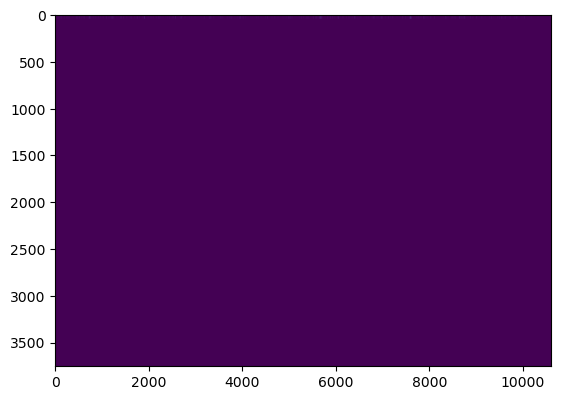

In [90]:
# Assuming the first 10 columns are metadata, and the rest are gene columns
gene_df = combined_df.iloc[:, 10:]  # Select all columns from the 11th onward

# Convert the gene DataFrame to a NumPy array
raw_gene_array = gene_df.to_numpy()

print(f"Gene array shape: {raw_gene_array.shape}")

plt.imshow(raw_gene_array, aspect=2)

In [91]:

# Assuming raw_gene_array is already defined and all values are of type float

# Calculate the minimum value
min_value = np.min(raw_gene_array)

# Calculate the maximum value
max_value = np.max(raw_gene_array)

# Calculate the median value
median_value = np.median(raw_gene_array)

# Calculate the mean value
mean_value = np.mean(raw_gene_array)

# Print the results
print(f"Minimum value: {min_value}")
print(f"Maximum value: {max_value}")
print(f"Median value: {median_value}")
print(f"Mean value: {mean_value}")


Minimum value: 0.0
Maximum value: 51568974.0
Median value: 3.388327323798745
Mean value: 8114.751873474826


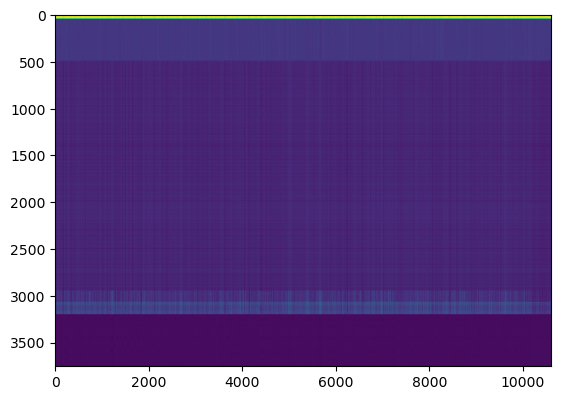

In [92]:
scaler = MinMaxScaler()
plt.imshow(scaler.fit_transform(np.log1p(raw_gene_array)), aspect=2)

### Basic preprocessing

Preprocessing levels per dataset: 
- AHBA (MH): Scaled-robust sigmoid --> min-max
- CBB (RNA-seq): TPM --> log-transform --> min-max
- UTSW (RNA-seq): RPKM (high values) --> log-transform --> min-max
- GTEx (RNA-seq): TPMs (log-transformed and 1st and 99th percentile clipped) --> min-max
- Yale HBT (MH): Raw --> min-max
- HBT Brainspan (RNA-seq): RPKM --> log-transform --> min-max

In [93]:
combined_df['dataset'].unique()

array(['UTSW Medical Center', 'Yale HBT', 'GTEx', 'HBT Brainspan',
       'Chinese Brain Bank', 'AHBA'], dtype=object)

In [94]:

def minimal_process_gene_data(combined_df):

    # Create a copy of the combined_df to avoid modifying the original DataFrame
    processed_df = combined_df.copy()
    
    # Define the preprocessing steps for each dataset
    preprocessing_steps = {
        'AHBA': ['scaled_robust_sigmoid'],
        'Chinese Brain Bank': ['log_transform', 'min_max'],
        'UTSW Medical Center': ['log_transform', 'min_max'],
        'GTEx': ['min_max'],
        'Yale HBT': ['min_max'],
        'HBT Brainspan': ['log_transform', 'min_max'] # something happening with these datasets that's causing weird norm
    }

    # Loop over each unique dataset
    for dataset in processed_df['dataset'].unique():
        # Initialize MinMaxScaler
        scaler = MinMaxScaler()
        
        # Subset the DataFrame by the current dataset
        dataset_df = processed_df[processed_df['dataset'] == dataset]

        # Get the gene columns (assuming they are from the 10th column onwards)
        gene_columns = dataset_df.columns[10:]

        # Perform the preprocessing steps
        steps = preprocessing_steps.get(dataset, [])
        if 'scaled_robust_sigmoid' in steps:
            # Apply the scaled robust sigmoid if needed (placeholder for actual implementation)
            pass
        
        if 'log_transform' in steps:
            # Apply Log + 1 Transform using .loc to avoid SettingWithCopyWarning
            processed_df.loc[dataset_df.index, gene_columns] = np.log1p(processed_df.loc[dataset_df.index, gene_columns])
        
        if 'min_max' in steps:
            # Apply Min-Max Scaling using .loc to avoid SettingWithCopyWarning
            scaled_values = scaler.fit_transform(processed_df.loc[dataset_df.index, gene_columns])
            processed_df.loc[dataset_df.index, gene_columns] = scaled_values

    return processed_df

minimal_processed_df = minimal_process_gene_data(combined_df)
print(minimal_processed_df.head())

     ID age sex ethnicity tissue sample local name  \
0  1029  30   M       NaN                     BA21   
1  1029  30   M       NaN                     BA22   
2  1029  30   M       NaN                     BA39   
3  1029  30   M       NaN                     BA40   
4  1029  30   M       NaN                     BA44   

                  tissue sample(s) in atlas name     atlas  \
0                    BA21: Middle temporal gyrus  Brodmann   
1                  BA22: Superior temporal gyrus  Brodmann   
2                            BA39: Angular gyrus  Brodmann   
3                      BA40: Supramarginal gyrus  Brodmann   
4  BA44: Pars opercularis (part of Broca's area)  Brodmann   

        centroid coordinates              dataset sequencing_type  ...  \
0   [(-61.68, -29.0, -9.41)]  UTSW Medical Center         RNA-Seq  ...   
1   [(-56.02, -21.08, 0.53)]  UTSW Medical Center         RNA-Seq  ...   
2  [(-47.88, -61.58, 30.79)]  UTSW Medical Center         RNA-Seq  ...   
3  [(-

Gene array shape: (3754, 10605)
[[0.50698252 0.80088477 0.60651388 ... 0.90909121 0.82683849 0.6853142 ]
 [0.33332055 0.86283197 0.6249587  ... 0.85454551 0.74891518 0.3916038 ]
 [0.63024088 0.65486696 0.48765368 ... 0.74545417 0.60172991 0.64335544]
 [0.39213098 0.7964598  0.12289224 ... 0.66060619 0.50216273 0.83216868]
 [0.68906096 0.64159285 0.59012538 ... 0.47272605 0.68830946 0.83916015]]


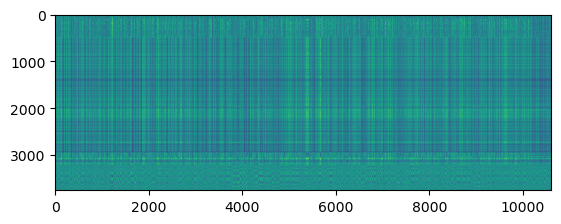

In [95]:
# Assuming the first 10 columns are metadata, and the rest are gene columns
gene_df = minimal_processed_df.iloc[:, 10:]  # Select all columns from the 11th onward

# Convert the gene DataFrame to a NumPy array
gene_array = gene_df.to_numpy()

# Print the shape of the resulting NumPy array to verify
print(f"Gene array shape: {gene_array.shape}")

# Optionally, print a small part of the array to check
print(gene_array[:5])

plt.imshow(gene_array)

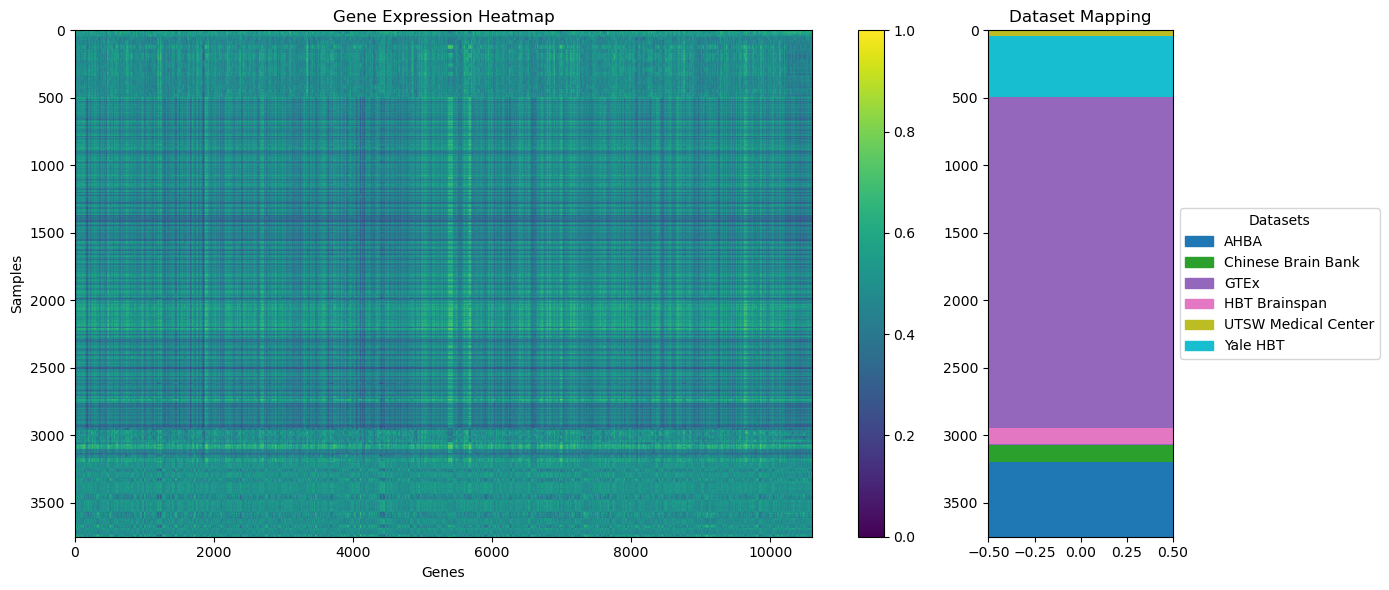

In [96]:
# Extract the dataset labels

# Extract the dataset labels
dataset_labels = minimal_processed_df['dataset'].values

# Convert dataset labels to unique integer identifiers for the legend
unique_datasets = np.unique(dataset_labels)
dataset_mapping = {label: idx for idx, label in enumerate(unique_datasets)}
mapped_labels = np.array([dataset_mapping[label] for label in dataset_labels])

# Create a colormap for the datasets
cmap = plt.get_cmap('tab10', len(unique_datasets))

# Create the figure with adjusted widths
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [5, 1]})

# Plot the gene expression heatmap
ax1.imshow(gene_array, aspect='auto', cmap='viridis')
ax1.set_title('Gene Expression Heatmap')
ax1.set_xlabel('Genes')
ax1.set_ylabel('Samples')

# Add colorbar to the heatmap
plt.colorbar(ax1.imshow(gene_array, aspect='auto', cmap='viridis'), ax=ax1)

# Plot the dataset mapping with a colormap
ax2.imshow(mapped_labels[:, np.newaxis], aspect='auto', cmap=cmap)
ax2.set_title('Dataset Mapping')

# Create a custom legend with dataset names
legend_handles = [Patch(color=cmap(i), label=unique_datasets[i]) for i in range(len(unique_datasets))]
ax2.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5), title="Datasets")

# Adjust layout
plt.tight_layout()
plt.show()

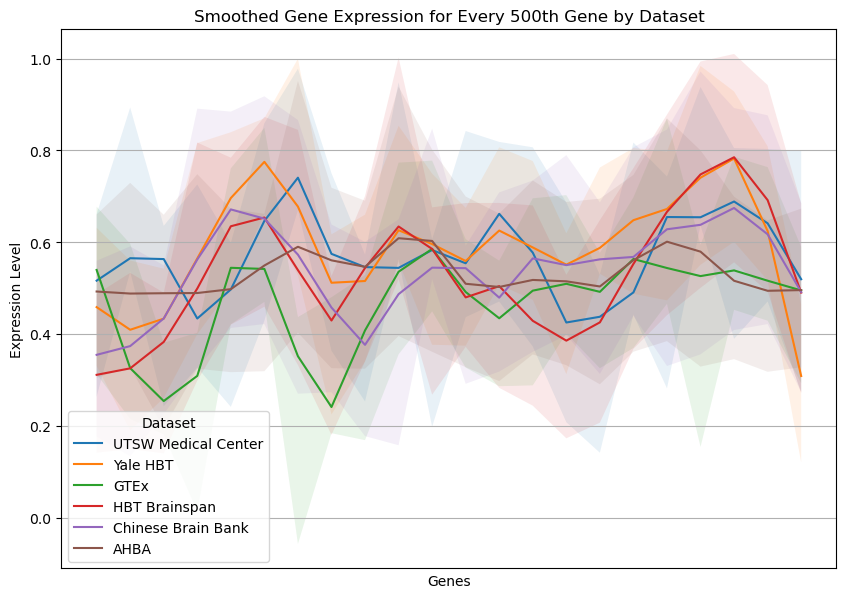

In [97]:


def lineplot_gene_expression_overview(minimal_processed_df):
    # Initialize a figure and axis
    plt.figure(figsize=(10, 7))

    # Loop over each unique dataset
    for dataset in minimal_processed_df['dataset'].unique():
        # Subset the DataFrame by the current dataset
        dataset_df = minimal_processed_df[minimal_processed_df['dataset'] == dataset]

        # Get the gene columns (assuming they are from the 10th column onwards)
        gene_columns = dataset_df.columns[10:]

        # [0:1000:len(gene_columns)]
        skip_num=500
        # Calculate the median and standard deviation for each gene
        median_values = dataset_df[gene_columns].median()[0:len(gene_columns):skip_num]
        std_values = dataset_df[gene_columns].std()[0:len(gene_columns):skip_num]

        # Apply Savitzky-Golay filter to smooth the median values
        smoothed_median_values = savgol_filter(median_values, window_length=5, polyorder=2)

        # Plot the line for the median values
        plt.plot(median_values.index, smoothed_median_values, label=dataset)

        # Add the shaded area representing standard deviation with lighter transparency
        plt.fill_between(median_values.index, 
                         median_values - std_values, 
                         median_values + std_values, 
                         alpha=0.1)  # Set transparency lighter with alpha=0.15
 
    
    # Customize the plot
    plt.title(f'Smoothed Gene Expression for Every {skip_num}th Gene by Dataset')
    plt.xlabel('Genes')
    plt.ylabel('Expression Level')
    plt.legend(title='Dataset')
    plt.grid(True)
    
    # Remove x-axis labels
    plt.xticks([])

    # Show the plot
    plt.show()

# Example usage
lineplot_gene_expression_overview(minimal_processed_df)


### Quick plot to show sampling density across the entire brain

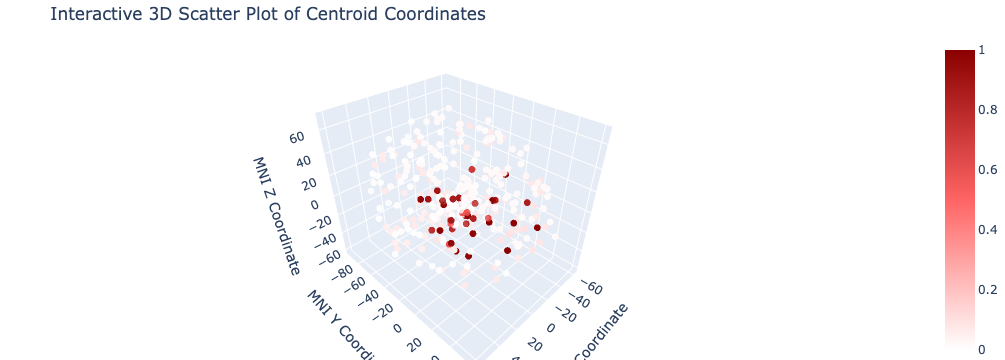

In [98]:
# Function to convert the string to a list of tuples
def parse_centroid_coordinates(coord_string):
    try:
        # Safely evaluate the string to a Python list
        return ast.literal_eval(coord_string)
    except (SyntaxError, ValueError):
        return None

# Extract all the centroid coordinates, converting strings to lists of tuples
all_coords = []

for coord_string in combined_df['centroid coordinates']:
    if coord_string and isinstance(coord_string, str):
        coords_list = parse_centroid_coordinates(coord_string)
        if coords_list is not None:
            # Filter out any None values within the coords_list
            valid_coords = [coord for coord in coords_list if coord is not None]
            all_coords.extend(valid_coords)

# Convert the list of tuples into a NumPy array for easier processing
coords_array = np.array(all_coords)

# Create a Counter object to count occurrences of each coordinate
coords_counter = Counter(map(tuple, coords_array))

# Convert the counts back into a list of colors based on frequency
colors = np.array([coords_counter[tuple(coord)] for coord in coords_array])

# Normalize colors to be between 0 and 1 for the colormap
colors_normalized = (colors - colors.min()) / (colors.max() - colors.min())

# Invert colors so that higher density is darker
colors_inverted =  colors_normalized

# Define a custom red gradient colormap
red_gradient = [
    [0.0, 'rgba(255, 255, 255, 1)'],  # Lightest red (almost white) for lowest density
    [0.5, 'rgba(255, 100, 100, 1)'],  # Medium red for intermediate density
    [1.0, 'rgba(139, 0, 0, 1)']       # Darkest red for highest density
]

# Create a 3D scatter plot using Plotly
trace = go.Scatter3d(
    x=coords_array[:, 0],
    y=coords_array[:, 1],
    z=coords_array[:, 2],
    mode='markers',
    marker=dict(
        size=4,  # Make the nodes slightly smaller
        color=colors_inverted,  # Use the inverted colors for density
        colorscale=red_gradient,  # Apply the custom red gradient colormap
        opacity=0.8,
        showscale=True
    ),
    text=[f"Density: {coords_counter[tuple(coord)]}" for coord in coords_array]
)

layout = go.Layout(
    scene=dict(
        xaxis_title='MNI X Coordinate',
        yaxis_title='MNI Y Coordinate',
        zaxis_title='MNI Z Coordinate',
    ),
    title='Interactive 3D Scatter Plot of Centroid Coordinates',
    margin=dict(l=0, r=0, b=0, t=40)
)

fig = go.Figure(data=[trace], layout=layout)

# Show the plot
fig.show()


### PCA

Raw data PCA (added some naive processing)

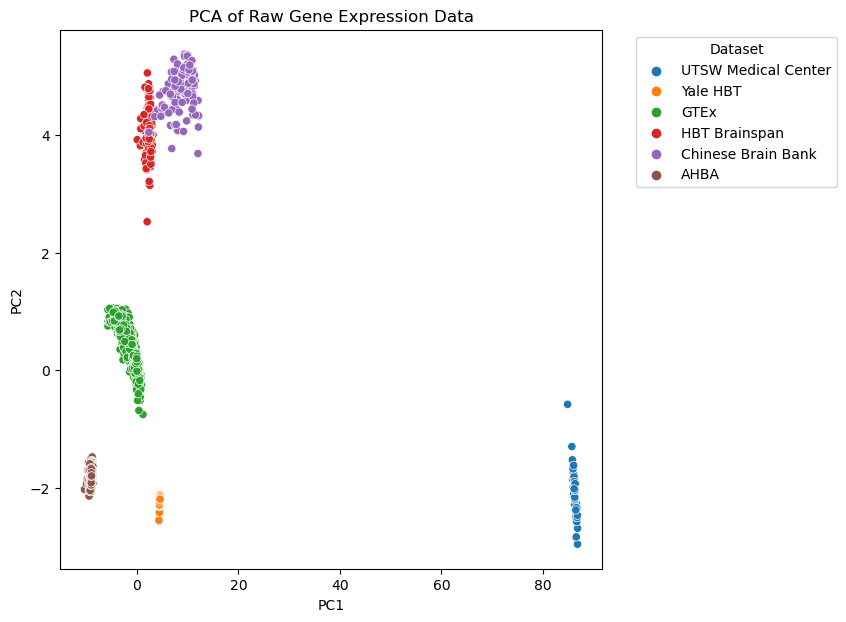

In [105]:
# Step 1: Extract gene expression data (assuming gene columns start from the 11th column onward)
gene_columns = combined_df.columns[10:]

# Step 2: Extract the gene data as a NumPy array
raw_gene_array = combined_df[gene_columns].to_numpy()

# Step 3: Perform PCA on raw data
pca_raw = PCA(n_components=2)
pca_raw_results = pca_raw.fit_transform(scaler.fit_transform(np.log1p(raw_gene_array)))

# Step 4: Plot PCA for raw data
plt.figure(figsize=(7, 7))
dataset_labels = combined_df['dataset'].values
sns.scatterplot(x=pca_raw_results[:, 0], y=pca_raw_results[:, 1], hue=dataset_labels, palette='tab10')
plt.title('PCA of Raw Gene Expression Data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

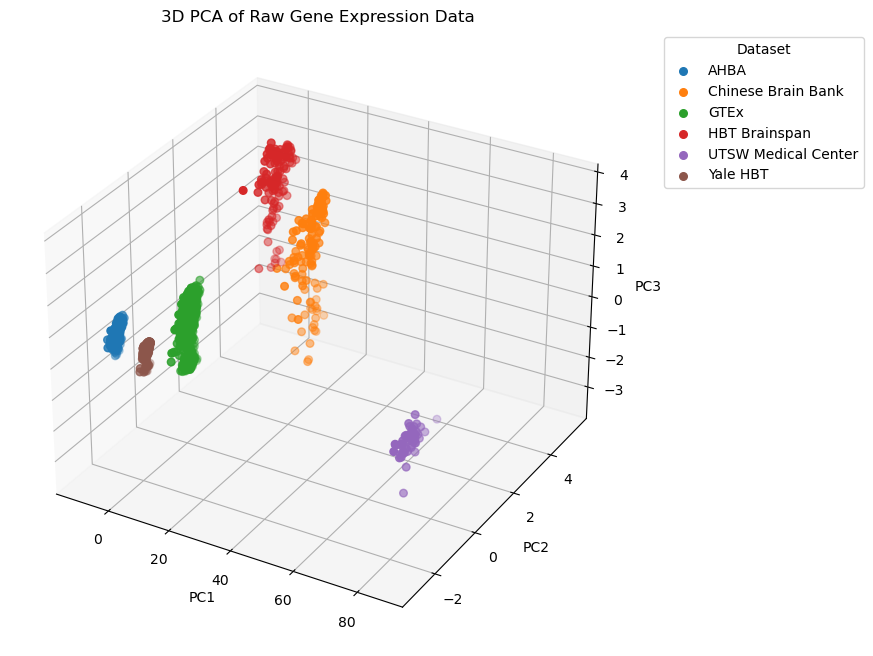

In [106]:


# Step 1: Extract gene expression data (assuming gene columns start from the 11th column onward)
gene_columns = combined_df.columns[10:]

# Step 2: Extract the gene data as a NumPy array
raw_gene_array = combined_df[gene_columns].to_numpy()

# Step 3: Perform PCA on raw data
pca_raw = PCA(n_components=3)
pca_raw_results = pca_raw.fit_transform(scaler.fit_transform(np.log1p(raw_gene_array)))

# Step 4: Plot 3D PCA for raw data
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

dataset_labels = combined_df['dataset'].values
unique_datasets = np.unique(dataset_labels)
colors = sns.color_palette("tab10", len(unique_datasets))

# Plot each dataset with a different color
for i, dataset in enumerate(unique_datasets):
    indices = np.where(dataset_labels == dataset)
    ax.scatter(pca_raw_results[indices, 0], pca_raw_results[indices, 1], pca_raw_results[indices, 2], 
               color=colors[i], label=dataset, s=30)

ax.set_title('3D PCA of Raw Gene Expression Data')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Minimally processed data PCA

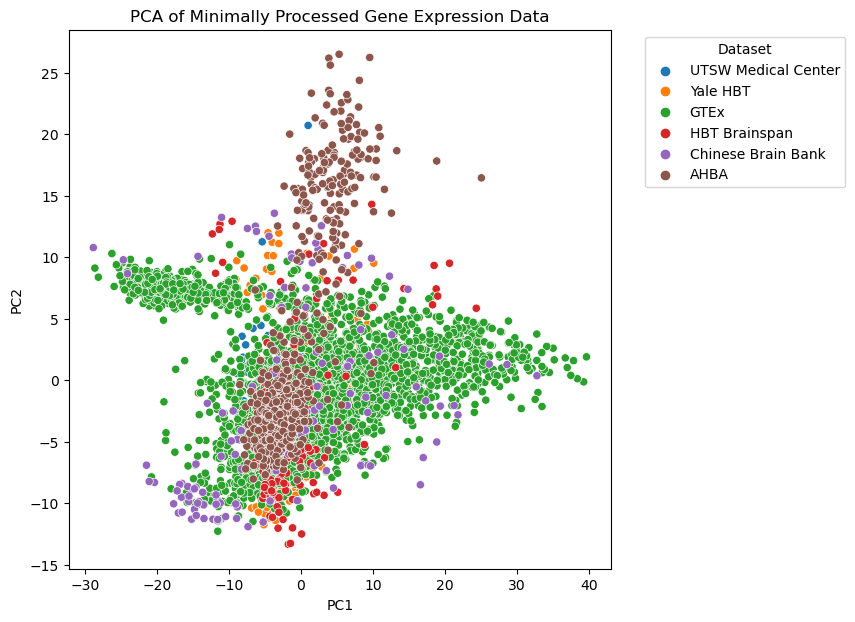

In [107]:
# Step 1: Extract gene expression data (assuming gene columns start from the 11th column onward)
gene_columns = minimal_processed_df.columns[10:]

# Step 2: Extract the gene data as a NumPy array
processed_gene_array = minimal_processed_df[gene_columns].to_numpy()

# Step 3: Perform PCA on minimally processed data
pca_processed = PCA(n_components=2)
pca_processed_results = pca_processed.fit_transform(processed_gene_array)

# Step 4: Plot PCA for minimally processed data
plt.figure(figsize=(7, 7))
dataset_labels = minimal_processed_df['dataset'].values
sns.scatterplot(x=pca_processed_results[:, 0], y=pca_processed_results[:, 1], hue=dataset_labels, palette='tab10')
plt.title('PCA of Minimally Processed Gene Expression Data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


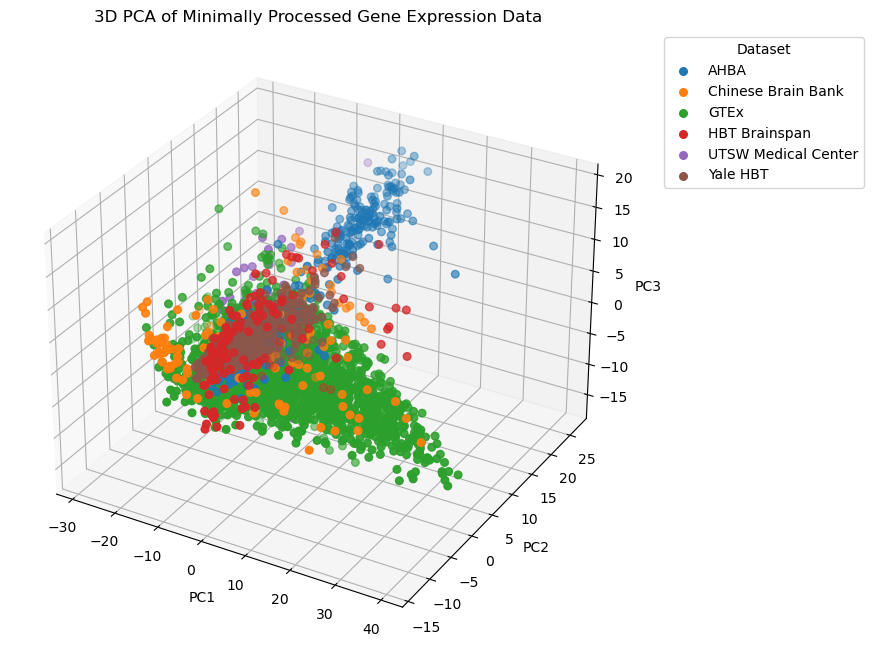

In [108]:
# Step 1: Extract gene expression data (assuming gene columns start from the 11th column onward)
gene_columns = minimal_processed_df.columns[10:]

# Step 2: Extract the gene data as a NumPy array
processed_gene_array = minimal_processed_df[gene_columns].to_numpy()

# Step 3: Perform PCA on minimally processed data
pca_processed = PCA(n_components=3)
pca_processed_results = pca_processed.fit_transform(processed_gene_array)

# Step 4: Plot 3D PCA for minimally processed data
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

dataset_labels = minimal_processed_df['dataset'].values
unique_datasets = np.unique(dataset_labels)
colors = sns.color_palette("tab10", len(unique_datasets))

# Plot each dataset with a different color
for i, dataset in enumerate(unique_datasets):
    indices = np.where(dataset_labels == dataset)
    ax.scatter(pca_processed_results[indices, 0], pca_processed_results[indices, 1], pca_processed_results[indices, 2], 
               color=colors[i], label=dataset, s=30)

ax.set_title('3D PCA of Minimally Processed Gene Expression Data')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### UMAP

In [167]:


def run_umap(dataframe, gene_columns_start=10, n_components=2, n_neighbors=15, min_dist=0.1, metric='euclidean', n_jobs=-1):
    """
    Run UMAP on the specified dataframe and return the UMAP results.

    Parameters:
    - dataframe: pd.DataFrame, the dataframe containing gene expression data.
    - gene_columns_start: int, the index of the first gene column in the dataframe (default is 10).
    - n_components: int, the number of dimensions to reduce the data to (default is 2).
    - n_neighbors: int, the number of neighbors to consider for UMAP (default is 15).
    - min_dist: float, the minimum distance between points for UMAP (default is 0.1).
    - metric: str, the metric to use for UMAP (default is 'euclidean').
    - n_jobs: int, the number of parallel jobs to run (default is -1, which uses all available cores).

    Returns:
    - umap_results: np.ndarray, the result of UMAP transformation.
    """
    # Step 1: Extract gene expression data
    gene_columns = dataframe.columns[gene_columns_start:]

    # Step 2: Extract the gene data as a NumPy array
    gene_array = dataframe[gene_columns].to_numpy()

    # Step 3: Perform UMAP with parallelization
    # add random_state here for replicability if desired!
    umap_model = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, metric=metric, n_jobs=n_jobs)
    umap_results = umap_model.fit_transform(gene_array)

    return umap_results

def plot_umap(umap_results, dataframe, title="UMAP Plot", color_by='dataset'):
    """
    Create a 2D or 3D UMAP plot using Plotly.

    Parameters:
    - umap_results: np.ndarray, the result of UMAP transformation.
    - dataframe: pd.DataFrame, the dataframe containing metadata for color coding.
    - title: str, the title of the plot (default is "UMAP Plot").
    """

    hover_data = {
        "Dataset": dataframe['dataset'],
        "Region": dataframe['tissue sample local name']
    }
    
    
    if umap_results.shape[1] == 2:
        # 2D UMAP Plot
        fig = px.scatter(
            x=umap_results[:, 0],
            y=umap_results[:, 1],
            color=dataframe[color_by],
            labels={'color': color_by},
            hover_data=hover_data,
            title=title
        )
        fig.update_traces(marker=dict(size=3))  # Adjust marker size if necessary

    elif umap_results.shape[1] == 3:
        # 3D UMAP Plot
        fig = px.scatter_3d(
            x=umap_results[:, 0],
            y=umap_results[:, 1],
            z=umap_results[:, 2],
            color=dataframe[color_by],
            labels={'color': color_by},
            hover_data=hover_data,

            title=title
        )
        fig.update_traces(marker=dict(size=2))  # Adjust marker size if necessary

    else:
        raise ValueError("UMAP results must have either 2 or 3 components.")

    fig.show()


Raw data

In [168]:
# Run UMAP for raw data (2D)
umap_results_raw_2d = run_umap(combined_df, n_components=2)

/ext3/miniconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



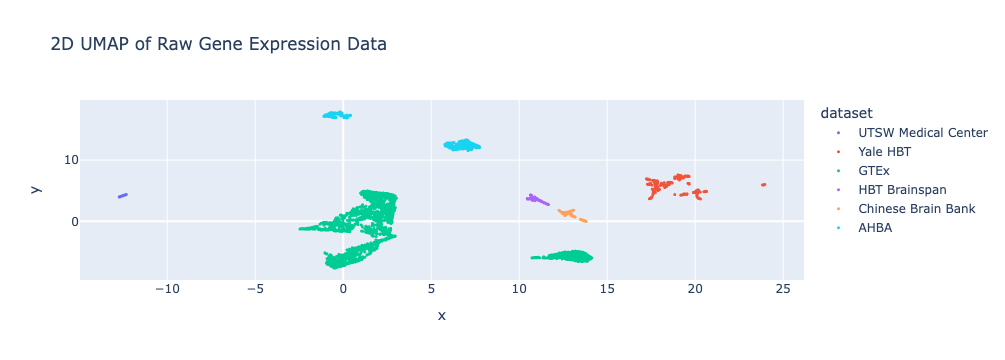

In [169]:
# Plot 2D UMAP for raw data
plot_umap(umap_results_raw_2d, combined_df, title="2D UMAP of Raw Gene Expression Data")

# umap_raw_results = umap_raw.fit_transform(scaler.fit_transform(np.log1p(raw_gene_array)))

In [170]:
# Run UMAP for raw data (3D)
umap_results_raw_3d = run_umap(combined_df, n_components=3)


In [171]:
# Plot 3D UMAP for raw data
plot_umap(umap_results_raw_3d, combined_df, title="3D UMAP of Raw Gene Expression Data")

3D

In [172]:
# Run UMAP for minimally processed data (2D)
umap_results_processed_2d = run_umap(minimal_processed_df, n_components=2)


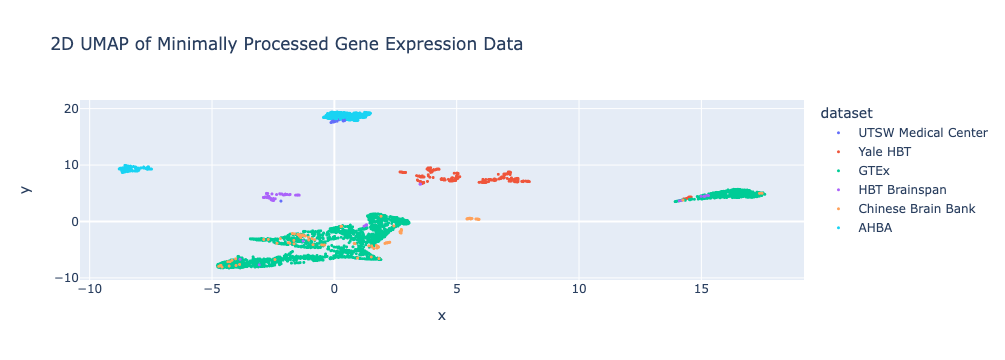

In [173]:
# Plot 2D UMAP for minimally processed data
plot_umap(umap_results_processed_2d, minimal_processed_df, title="2D UMAP of Minimally Processed Gene Expression Data")


In [174]:
# Run UMAP for minimally processed data (3D)
umap_results_processed_3d = run_umap(minimal_processed_df, n_components=3)

In [175]:
# Plot 3D UMAP for minimally processed data
plot_umap(umap_results_processed_3d, minimal_processed_df, title="3D UMAP of Minimally Processed Gene Expression Data")

In [177]:
plot_umap(umap_results_processed_3d, minimal_processed_df, title="3D UMAP of Minimally Processed Gene Expression Data", color_by='sequencing_type')